In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [2]:
df = pd.read_csv("cleaned_final_dataset.csv")
df.describe

<bound method NDFrame.describe of                Region    Country  Year  AvgTemperature  Happiness Index  \
0              Africa    Algeria  2005       62.913425         5.466833   
1              Africa    Algeria  2006       64.930411         5.466833   
2              Africa    Algeria  2007       63.166849         5.466833   
3              Africa    Algeria  2008       63.532240         5.466833   
4              Africa    Algeria  2009       64.259726         5.466833   
...               ...        ...   ...             ...              ...   
1136  Western Pacific  Singapore  2015       81.980328         6.033000   
1137  Western Pacific  Singapore  2016       81.303005         6.378000   
1138  Western Pacific  Singapore  2017       81.988219         6.375000   
1139  Western Pacific  Singapore  2018       80.348219         6.378000   
1140  Western Pacific  Singapore  2019       80.324384         6.448000   

               GDP  Population  Both sexes  Female   Male  
0    

In [3]:
def categorize_rate(rate):
    if rate < df['Both sexes'].quantile(0.33):
        return 'Low'
    elif rate < df['Both sexes'].quantile(0.66):
        return 'Medium'
    else:
        return 'High'

df['risk_category'] = df['Both sexes'].apply(categorize_rate)
df.head()

,Region,Country,Year,AvgTemperature,Happiness Index,GDP,Population,Both sexes,Female,Male,risk_category
0,Africa,Algeria,2005,62.913425,5.466833,3131.328300,32956690.0,3.82,2.80,4.83,Low
1,Africa,Algeria,2006,64.930411,5.466833,3500.134528,33435080.0,3.65,2.66,4.63,Low
2,Africa,Algeria,2007,63.166849,5.466833,3971.803658,33983827.0,3.46,2.51,4.41,Low
3,Africa,Algeria,2008,63.532240,5.466833,4946.563793,34569592.0,3.31,2.40,4.22,Low
4,Africa,Algeria,2009,64.259726,5.466833,3898.478923,35196037.0,3.15,2.29,4.02,Low


In [4]:
le_region = LabelEncoder()
le_country = LabelEncoder()
le_risk = LabelEncoder()

df['Region'] = le_region.fit_transform(df['Region'])
df['Country'] = le_country.fit_transform(df['Country'])
# Encode 'Low'=0, 'Medium'=1, 'High'=2
df['risk_category'] = le_risk.fit_transform(df['risk_category'])

In [5]:
X = df.drop(['Both sexes', 'Female', 'Male', 'risk_category'], axis = 1)
y = df['risk_category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
xgb_model = XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=3, num_parallel_tree=None, ...)

Using SMOTE to Balance the Dataset:  
If there is a class imbalance in your dataset, you can use SMOTE to perform oversampling.

In [7]:
y_pred = xgb_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le_risk.classes_))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Training
xgboost_model = XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss', random_state=42)
xgboost_model.fit(X_train_res, y_train_res)

# Evaluate
y_pred_res = xgboost_model.predict(X_test)
print("Accuracy after SMOTE:", accuracy_score(y_test, y_pred_res))
print("Classification Report after SMOTE:\n", classification_report(y_test, y_pred_res))

Accuracy: 0.9344978165938864
Classification Report:
               precision    recall  f1-score   support

        High       0.95      0.94      0.94        78
         Low       0.96      0.96      0.96        76
      Medium       0.89      0.91      0.90        75

    accuracy                           0.93       229
   macro avg       0.93      0.93      0.93       229
weighted avg       0.93      0.93      0.93       229

Confusion Matrix:
 [[73  0  5]
 [ 0 73  3]
 [ 4  3 68]]
Accuracy after SMOTE: 0.9301310043668122
Classification Report after SMOTE:
               precision    recall  f1-score   support

           0       0.95      0.92      0.94        78
           1       0.96      0.96      0.96        76
           2       0.88      0.91      0.89        75

    accuracy                           0.93       229
   macro avg       0.93      0.93      0.93       229
weighted avg       0.93      0.93      0.93       229



1. Accuracy:  
Before SMOTE: 93.45%  
After SMOTE: 93.01%  
Accuracy is the proportion of correct predictions (both true positives and true negatives) out of all predictions. In this case, the accuracy is very high both before and after applying SMOTE, and the change in accuracy is very small, indicating that SMOTE did not harm the model's performance. However, SMOTE's main purpose is to address class imbalance, not to improve accuracy, so a slight decrease in accuracy could be acceptable if it improves other metrics like recall or F1-score.  

2. Precision, Recall, and F1-Score:  
These metrics help us understand how well the model performs for each class (Low, Medium, High) and balance between false positives and false negatives.  

- Before SMOTE:  
Precision and recall are quite high for all classes, with values around 0.94 or higher for most classes. This means that the model is good at correctly identifying each category and rarely misclassifies data.  
High: Precision = 0.95, Recall = 0.94, F1-score = 0.94  
Low: Precision = 0.96, Recall = 0.96, F1-score = 0.96  
Medium: Precision = 0.89, Recall = 0.91, F1-score = 0.90  
- After SMOTE:  
The precision and recall scores after applying SMOTE are also very good and fairly similar to the scores before SMOTE. This indicates that SMOTE didn't significantly change the classification ability for each class.  
High: Precision = 0.95, Recall = 0.92, F1-score = 0.94  
Low: Precision = 0.96, Recall = 0.96, F1-score = 0.96  
Medium: Precision = 0.88, Recall = 0.91, F1-score = 0.89  
Key observation: There is a slight drop in precision for the "High" and "Medium" classes after applying SMOTE, but the recall and F1-score remain similar or slightly improved. This suggests that SMOTE may have helped in addressing the class imbalance without causing major issues in terms of precision or recall. 

3. Confusion Matrix:  
The confusion matrix is almost identical to the one before SMOTE, indicating that the synthetic data created by SMOTE did not cause significant misclassification or bias.  

4. Conclusion:  
In conclusion, the model demonstrates strong performance across all key metrics—accuracy, precision, recall, and F1-score—indicating its overall effectiveness in classifying the data. The application of SMOTE did not result in any significant drop in performance, suggesting that the technique is successful in addressing class imbalance without negatively impacting the model’s predictive power.


Hyperparameter Tuning  
Use GridSearchCV or RandomizedSearchCV to optimize hyperparameters

In [8]:
params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2],  
    'min_child_weight': [1, 3, 5]
}

grid = GridSearchCV(
    estimator=XGBClassifier(objective='multi:softmax', num_class=3, random_state=42),
    param_grid=params,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test)
best_accuracy = accuracy_score(y_test, y_pred_best)

print("Best Parameters:", grid.best_params_)
print(f'Best Model Accuracy: {best_accuracy}')

Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Best Model Accuracy: 0.9344978165938864


In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Calculate precision, recall, and F1-score for each class
precision = precision_score(y_test, y_pred, average=None)  # None for class-wise
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

print("Precision per class:", precision)
print("Recall per class:", recall)
print("F1 Score per class:", f1)

# You can also print the classification report for a more detailed summary
print("Classification Report:\n", classification_report(y_test, y_pred))

Precision per class: [0.94805195 0.96052632 0.89473684]
Recall per class: [0.93589744 0.96052632 0.90666667]
F1 Score per class: [0.94193548 0.96052632 0.90066225]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.94        78
           1       0.96      0.96      0.96        76
           2       0.89      0.91      0.90        75

    accuracy                           0.93       229
   macro avg       0.93      0.93      0.93       229
weighted avg       0.93      0.93      0.93       229



1. Plot Feature Importance  
Feature importance helps you understand which features have the most impact on your model’s predictions. XGBoost provides a built-in function to plot the importance of features.

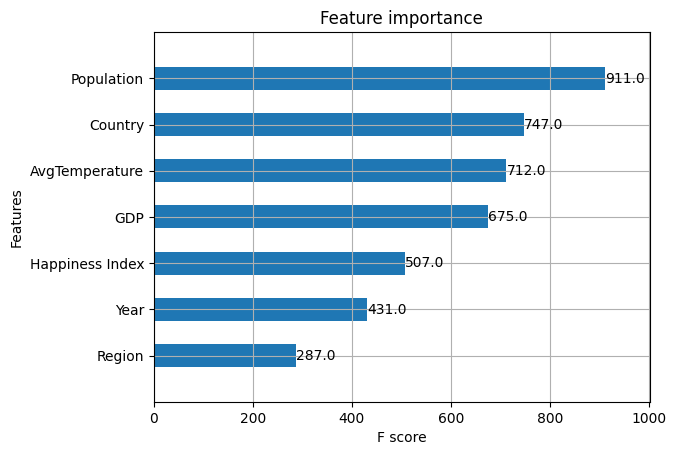

In [10]:
plot_importance(xgb_model, max_num_features=10, importance_type='weight', height=0.5)
plt.show()

2. Plot Confusion Matrix  
A confusion matrix is a great way to visualize the performance of your model, especially for classification tasks.

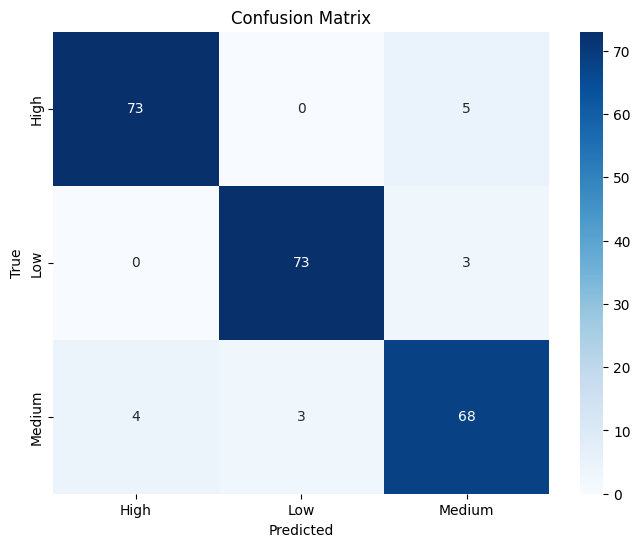

In [11]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_risk.classes_, yticklabels=le_risk.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

3. Plot Precision-Recall Curve  
Precision-Recall curves are particularly useful when dealing with imbalanced datasets. They show the trade-off between precision and recall for different thresholds.

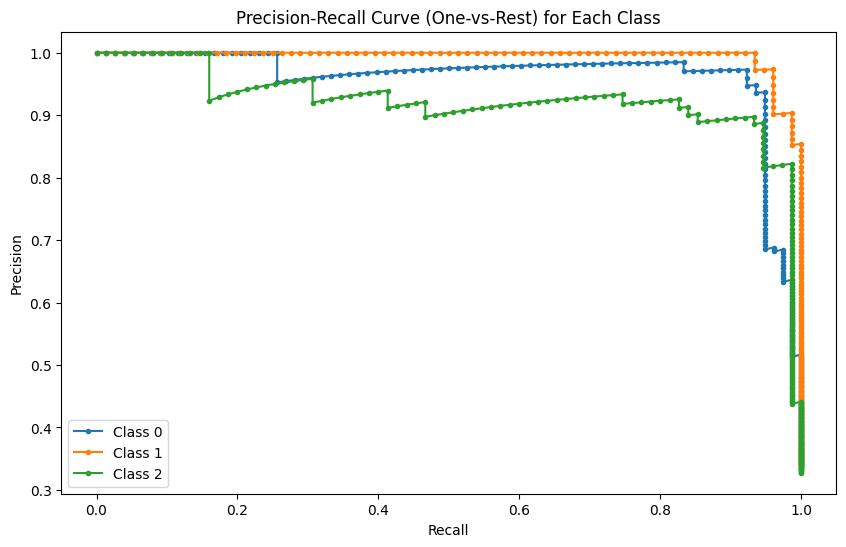

In [12]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Convert y_test to binary format for multi-class (one-hot encoding)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # Adjust classes based on your class labels

# Get predicted probabilities for each class (assumes your model has been trained)
y_pred_prob = xgb_model.predict_proba(X_test)

# Plot precision-recall curve for each class
plt.figure(figsize=(10, 6))

for i in range(y_test_bin.shape[1]):  # Loop through each class
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, marker='.', label=f'Class {i}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (One-vs-Rest) for Each Class')
plt.legend(loc='best')
plt.show()